# Age prediction males informative region


In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import umap
from itertools import cycle
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot
from utilities import montecarlo_crossvalidation
from utilities import model_optimization
from utilities import variable_importance_df
from utilities import gridsearch_bias

/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [5]:
tsetse_data_copy = tsetse_data.copy()

In [6]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data_copy[dList]

In [7]:
tsetse_males_thorax = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'm') & (descriptorsDF['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'm') & (descriptorsDF['Tissue'] == 'Head')]

In [8]:
tsetse_males_thorax.groupby("Age")["ID"].count()

Age
5w    93
7w    92
Name: ID, dtype: int64

In [9]:
tsetse_males_head.groupby("Age")["ID"].count()

Age
5w    94
7w    93
Name: ID, dtype: int64

In [10]:
tsetse_males_thorax_copy = tsetse_males_thorax.copy()
tsetse_males_head_copy = tsetse_males_head.copy()

In [11]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF_thorax = tsetse_males_thorax[dList]
tsetse_males_thorax_copy.drop(dList, axis=1,inplace=True)


descriptorsDF_head = tsetse_males_head_copy[dList]
tsetse_males_head_copy.drop(dList, axis=1,inplace=True)

In [12]:
waveNumslist = tsetse_males_thorax_copy.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [13]:
y_labels_head = descriptorsDF_head['Age']
y_labels_thorax = descriptorsDF_thorax['Age']

## Age prediction males

In [19]:
X_thorax = tsetse_males_thorax.loc[:,"1800":"602"]
y_thorax = tsetse_males_thorax.loc[:,"Age"]

X_head = tsetse_males_head.loc[:,"1800":"602"]
y_head = tsetse_males_head.loc[:,"Age"]

waveNumslist_reduced = X_thorax.columns.values.tolist()
wavenumbers_reduced = [int(x) for x in waveNumslist_reduced]

In [15]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [16]:
shape_data = {"train_head": X_hd_train.shape,
              "train_thorax": X_th_train.shape,
              "test_head": X_hd_test.shape,
              "tsetse_thorax":X_th_test.shape}

In [17]:
shape_data_df = pd.DataFrame(shape_data,index=['samples','features'])
shape_data_df

,train_head,train_thorax,test_head,tsetse_thorax
samples,149,148,38,37
features,600,600,600,600


In [18]:
shape_data_classes = {"train_head": y_hd_train.value_counts(),
              "train_thorax": y_th_train.value_counts(),
              "test_head": y_hd_test.value_counts(),
              "tsetse_thorax":y_th_test.value_counts()}

shape_data_classes_df = pd.DataFrame(shape_data_classes)
shape_data_classes_df


,train_head,train_thorax,test_head,tsetse_thorax
Age,,,,
5w,68,71,26,22
7w,81,77,12,15


In [20]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [21]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

<Axes: xlabel='param_clf', ylabel='value'>

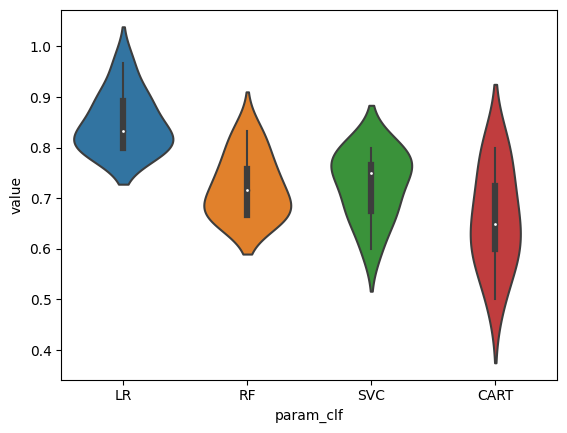

In [23]:
sn.violinplot(data=data_plot_head, x='param_clf',y='value')

In [127]:
output = data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.660000  0.099132
1        LR  0.850000  0.057198
2        RF  0.723333  0.060959
3       SVC  0.726667  0.066295


In [128]:
output = data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.700000  0.056656
1        LR  0.820000  0.059213
2        RF  0.736667  0.085274
3       SVC  0.786667  0.059213


In [24]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)


Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [25]:
# thorax

best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [26]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [27]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9736842105263158
Accuracy on test set: 0.8378378378378378


In [28]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
5w,1.000000,0.961538,0.980392,26.000000
7w,0.923077,1.000000,0.960000,12.000000
accuracy,0.973684,0.973684,0.973684,0.973684
macro avg,0.961538,0.980769,0.970196,38.000000
weighted avg,0.975709,0.973684,0.973953,38.000000


In [29]:
report_head.to_excel("../results/tables/informative_region_results/accuracy_age_males_head.xlsx")

In [30]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
5w,0.863636,0.863636,0.863636,22.000000
7w,0.800000,0.800000,0.800000,15.000000
accuracy,0.837838,0.837838,0.837838,0.837838
macro avg,0.831818,0.831818,0.831818,37.000000
weighted avg,0.837838,0.837838,0.837838,37.000000


In [31]:
report_thorax.to_excel("../results/tables/informative_region_results/accuracy_age_males_thorax.xlsx")

In [32]:
roc_head = roc_auc_score(y_hd_test, pipe_head.predict_proba(X_hd_test)[:,1])

In [33]:
auc_roc_results = pd.DataFrame({"ROC value": [roc_auc_score(y_hd_test, pipe_head.predict_proba(X_hd_test)[:,1]), roc_auc_score(y_th_test, pipe_thorax.predict_proba(X_th_test)[:,1])]},index=['head','thorax'])

print(auc_roc_results)

auc_roc_results.to_excel("../results/tables/informative_region_results/roc_values_age_males.xlsx")


        ROC value
head     1.000000
thorax   0.933333


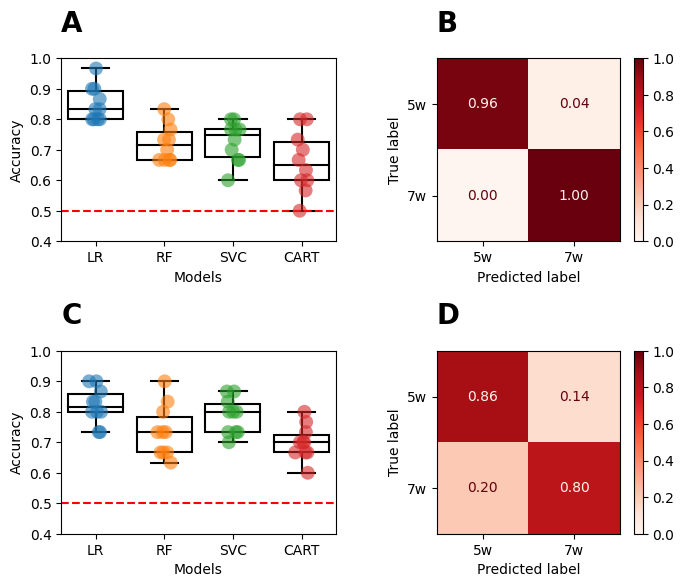

In [50]:
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,6))

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})

sn.boxplot(data=data_plot_head, x='param_clf', y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value', ax=ax,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax.lines, color='k')
ax.axhline(0.5, color='r',ls='--')
ax.set_ylim(0.4,1)
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
for i,box in enumerate(ax.patches):
    box.set_edgecolor('black')


sn.boxplot(data=data_plot_thorax, x='param_clf', y='value',ax=ax3, color='white')
sn.stripplot(data=data_plot_thorax, x='param_clf',y='value', ax=ax3,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax3.lines, color='k')
ax3.axhline(0.5, color='r',ls='--')
ax3.set_ylim(0.4,1)
ax3.set_xlabel("Models")
ax3.set_ylabel("Accuracy")
for i,box in enumerate(ax3.patches):
    box.set_edgecolor('black')

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


labeles = ['A','B','C','D']
axess = [ax, ax2, ax3, ax4]
for k, l in zip(axess, labeles):
    k.set_title(l,y=1.1,weight='bold',loc='left', fontsize=20)


plt.tight_layout()

#plt.savefig("../results/plots/informative_region//age_prediction_males.png", dpi=300)

In [37]:
top20_head = variable_importance_df(wavenumbers_reduced, best_model_head)
top20_thorax = variable_importance_df(wavenumbers_reduced, best_mdoel_thorax)

In [38]:
top20_thorax

,Wavenumbers,Coefficients
22,1756,4.929739
17,1766,3.704480
21,1758,3.699632
18,1764,3.667899
343,1114,2.453589
342,1116,2.358417
341,1118,2.358417
507,786,2.283714
508,784,2.283435
52,1696,2.256942


<Axes: title={'center': 'Head'}, xlabel='Wavenumbers', ylabel='Coefficients'>

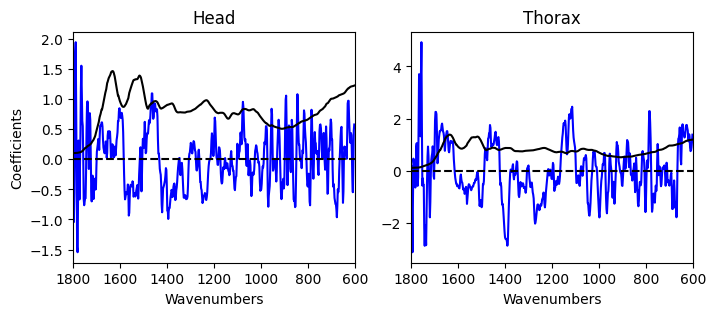

In [44]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(8,3),sharex=True)

sn.lineplot(x=wavenumbers_reduced,y=best_model_head['model'].coef_[0], color='b',ax=ax)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)),color='k',alpha=0.5,ax=ax)
ax.axhline(y=0, color="k", ls="--")
ax.set_xlim(1800,600)
#ax.annotate('1464', xy=(1464,0.4214), xycoords='data',fontsize=10)
#ax.annotate('1678', xy=(1678,0.3214), xycoords='data',fontsize=10)
#ax.annotate('816', xy=(816,0.344), xycoords='data',fontsize=10)
#ax.annotate('1400', xy=(1464,-0.45), xycoords='data',fontsize=10)
#ax.annotate('1562', xy=(1562,-0.42), xycoords='data',fontsize=10)
ax.set_xlabel("Wavenumbers")
ax.set_ylabel("Coefficients")
ax.set_title("Head")


sn.lineplot(x=wavenumbers_reduced,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax2)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*6),color='k',alpha=0.5,ax=ax2)
ax2.axhline(y=0, color="k", ls="--")
ax2.set_xlabel("Wavenumbers")
ax2.set_title("Thorax")
#ax2.annotate('782', xy=(782,3.59), xycoords='data',fontsize=10)
#ax2.annotate('1750', xy=(1750,3.214), xycoords='data',fontsize=10)
#ax2.annotate('1464', xy=(1464,3.44), xycoords='data',fontsize=10)
#ax2.annotate('1692', xy=(1692, 2.785488), xycoords='data',fontsize=10)
#ax2.annotate('772', xy=(772,-2.59), xycoords='data',fontsize=10)

#ax2.annotate('686', xy=(686,	-2.576248), xycoords='data',fontsize=10)
#ax2.annotate('1720', xy=(1720, -2.324863), xycoords='data',fontsize=10)

#ax2.annotate('1040', xy=(1040,-2.260752), xycoords='data',fontsize=10)

sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*5),color='k',ax=ax2)
sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_head ,axis=0)*5),color='k',ax=ax)

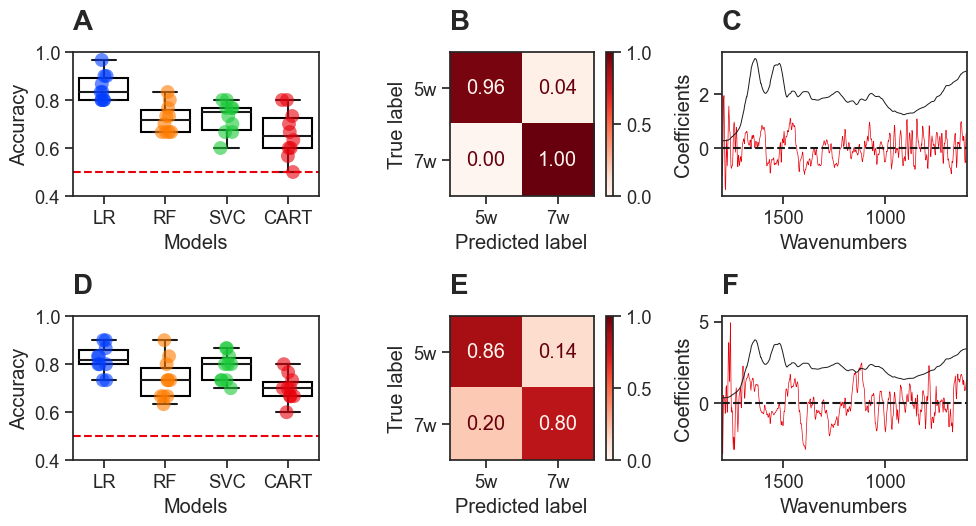

In [103]:
# final plot
sn.set(font_scale=1.2)
sn.set_palette('bright', color_codes=True)
sn.set_style('ticks')

fig, ((ax,ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10,5.5), tight_layout='True')

sn.boxplot(data=data_plot_head, x='param_clf', y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value', ax=ax,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax.lines, color='k')

ax.axhline(0.5, color='r',ls='--')
ax.set_ylim(0.4,1)
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
for i,box in enumerate(ax.patches):
    box.set_edgecolor('black')

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0., 'vmax':1.})


sn.lineplot(x=wavenumbers_reduced,y=best_model_head['model'].coef_[0], color='r',ax=ax3, linewidth=0.5)
ax3.axhline(y=0, color="k", ls="--")
ax3.set_xlim(1800,600)
ax3.set_xlabel("Wavenumbers")
ax3.set_ylabel("Coefficients")
ax6.set_ylabel("Coefficients")
sn.lineplot(x=wavenumbers_reduced,y=np.mean(X_thorax, axis=0)*12, color='k',ax=ax3, linewidth=0.7)

sn.boxplot(data=data_plot_thorax, x='param_clf', y='value',ax=ax4, color='white')
sn.stripplot(data=data_plot_thorax, x='param_clf',y='value', ax=ax4,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax4.lines, color='k')
ax4.axhline(0.5, color='r',ls='--')
ax4.set_ylim(0.4,1)
ax4.set_xlabel("Models")
ax4.set_ylabel("Accuracy")
for i,box in enumerate(ax4.patches):
    box.set_edgecolor('black')

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax5, im_kw={'vmin':0., 'vmax':1.})




sn.lineplot(x=wavenumbers_reduced,y=best_mdoel_thorax['model'].coef_[0], color='r',ax=ax6, linewidth=0.5)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*6),color='k',alpha=0.5,ax=ax2)
ax6.axhline(y=0, color="k", ls="--")
ax6.set_xlabel("Wavenumbers")
ax6.set_xlim(1800,600)
sn.lineplot(x=wavenumbers_reduced,y=np.mean(X_thorax, axis=0)*14, color='k',ax=ax6, linewidth=0.7)

labeles = ['A','B','C','D','E',"F"]
axess = [ax, ax2, ax3, ax4,ax5,ax6]
for k, l in zip(axess, labeles):
    k.set_title(l,y=1.1,weight='bold',loc='left', fontsize=20)





plt.savefig("../results/plots/informative_region/age_prediction_males.png", dpi=900,bbox_inches='tight')


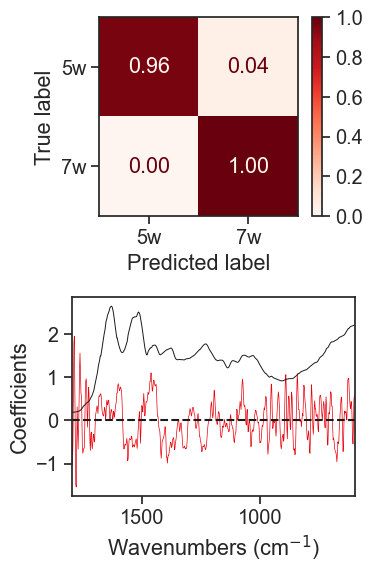

In [134]:
# final plot
# confusion matrix and ocnefficients of the head

sn.set(font_scale=1.3)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(2,1, figsize=(4,6), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0., 'vmax':1.})

sn.lineplot(x=wavenumbers_reduced,y=best_model_head['model'].coef_[0], color='r',ax=ax2, linewidth=0.5)
ax2.axhline(y=0, color="k", ls="--")
ax2.set_xlim(1800,600)
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")
ax2.set_ylabel("Coefficients")

sn.lineplot(x=wavenumbers_reduced,y=np.mean(X_head, axis=0)*9, color='k',ax=ax2, linewidth=0.7)

plt.savefig("../results/plots/final_plots/age_prediction_head.png", dpi=900)





In [129]:
topwavenumbers = variable_importance_df(wavenumbers_reduced,best_model_head)
topwavenumbers

,Wavenumbers,Coefficients
6,1788,1.945759
5,1790,1.764352
18,1764,1.555167
17,1766,1.177562
168,1464,1.096210
169,1462,1.093712
478,844,1.081539
454,892,1.057962
19,1762,1.053931
453,894,0.996315


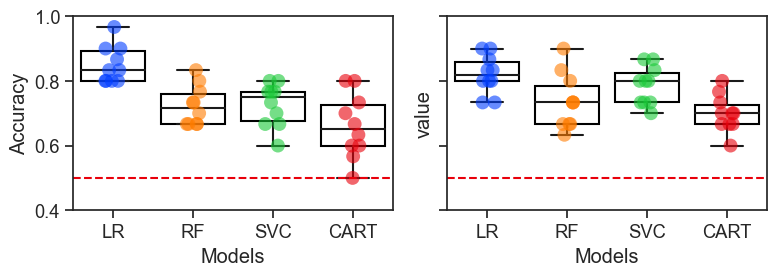

In [124]:
# suplementary material training


sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax,ax2)) = plt.subplots(1,2, figsize=(8,3), tight_layout=True, sharey=True)


sn.boxplot(data=data_plot_head, x='param_clf', y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value', ax=ax,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax.lines, color='k')
ax.axhline(0.5, color='r',ls='--')


sn.boxplot(data=data_plot_thorax, x='param_clf', y='value',ax=ax2, color='white')
sn.stripplot(data=data_plot_thorax, x='param_clf',y='value', ax=ax2,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax2.lines, color='k')
ax.set_ylim(0.4,1)
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
for i,box in enumerate(ax.patches):
    box.set_edgecolor('black')


plt.setp(ax2.lines, color='k')
ax2.axhline(0.5, color='r',ls='--')
ax2.set_ylim(0.4,1)
ax2.set_xlabel("Models")
for i,box in enumerate(ax2.patches):
    box.set_edgecolor('black')


plt.savefig("../results/plots/final_plots/males_ageprediction_training_suplementary.png", dpi=300)

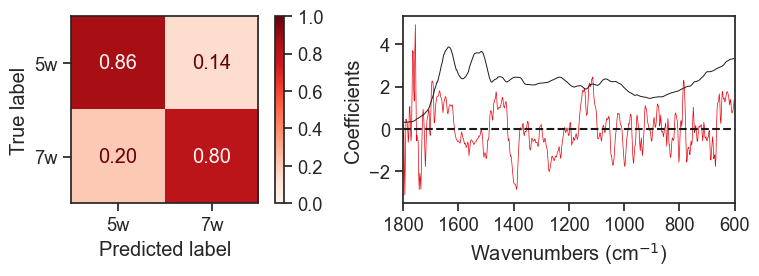

In [125]:
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0., 'vmax':1.})

sn.lineplot(x=wavenumbers_reduced,y=best_mdoel_thorax['model'].coef_[0], color='r',ax=ax2, linewidth=0.5)
ax2.axhline(y=0, color="k", ls="--")
ax2.set_xlim(1800,600)
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")
ax2.set_ylabel("Coefficients")

sn.lineplot(x=wavenumbers_reduced,y=np.mean(X_thorax, axis=0)*14, color='k',ax=ax2, linewidth=0.7)

plt.savefig("../results/plots/final_plots/males_ageprediction_thorax_suplementary.png", dpi=300)

In [135]:
accuracy_head_mc, a, b = montecarlo_crossvalidation(X_head, y_head, best_model_head, binary=True)

shuffle split: 100%|██████████| 100/100 [00:06<00:00, 14.70it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.86 ± 0.06


In [136]:
accuracy_thorax_mc, a, b = montecarlo_crossvalidation(X_thorax, y_thorax, best_mdoel_thorax, binary=False)

shuffle split: 100%|██████████| 100/100 [00:06<00:00, 14.69it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.91 ± 0.05
